Import the data from Edge Impulse. You can obtain the URL from the Dashboard, right-click on the download icon next to 'Spectral features data' and 'Spectral features labels', and click **Copy link location**.

In [5]:
import numpy as np
import requests

API_KEY = 'ei_a4a199d2c331dd57709baf622fca6b83528f34504943bad629b613d38a1e4b17'

X = (requests.get('https://studio.edgeimpulse.com/v1/api/3973/training/7/x', headers={'x-api-key': API_KEY})).content
Y = (requests.get('https://studio.edgeimpulse.com/v1/api/3973/training/7/y', headers={'x-api-key': API_KEY})).content

Store the data in a temporary file, and load it back through Numpy.

In [6]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [7]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "cough", "no_cough" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def set_batch_size(batch_size, train_dataset, validation_dataset):
    shuffle_buffer_size = batch_size * 3
    train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)
    validation_dataset = validation_dataset.shuffle(shuffle_buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)
    return train_dataset, validation_dataset

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)


# Train the model

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, SeparableConv1D, Reshape, MaxPooling1D, AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
# model architecture
model = Sequential()
model.add(InputLayer(input_shape=(input_length, ), name='x_input'))
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(30, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=5, padding='same'))
model.add(SeparableConv1D(10, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=5, padding='same'))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)

# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 1
train_dataset, validation_dataset = set_batch_size(BATCH_SIZE, train_dataset, validation_dataset)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, verbose=2, callbacks=[callbacks])


Epoch 1/200
550/550 - 3s - loss: 0.6808 - accuracy: 0.5545 - val_loss: 0.6494 - val_accuracy: 0.5408
Epoch 2/200
550/550 - 1s - loss: 0.6618 - accuracy: 0.6200 - val_loss: 0.6377 - val_accuracy: 0.6837
Epoch 3/200
550/550 - 1s - loss: 0.6502 - accuracy: 0.6600 - val_loss: 0.6289 - val_accuracy: 0.6837
Epoch 4/200
550/550 - 1s - loss: 0.6408 - accuracy: 0.6600 - val_loss: 0.6220 - val_accuracy: 0.6837
Epoch 5/200
550/550 - 1s - loss: 0.6323 - accuracy: 0.6673 - val_loss: 0.6159 - val_accuracy: 0.6837
Epoch 6/200
550/550 - 1s - loss: 0.6238 - accuracy: 0.6709 - val_loss: 0.6096 - val_accuracy: 0.6837
Epoch 7/200
550/550 - 1s - loss: 0.6154 - accuracy: 0.6818 - val_loss: 0.6033 - val_accuracy: 0.7245
Epoch 8/200
550/550 - 1s - loss: 0.6072 - accuracy: 0.6909 - val_loss: 0.5970 - val_accuracy: 0.7347
Epoch 9/200
550/550 - 1s - loss: 0.5991 - accuracy: 0.7036 - val_loss: 0.5909 - val_accuracy: 0.7347
Epoch 10/200
550/550 - 1s - loss: 0.5911 - accuracy: 0.7164 - val_loss: 0.5848 - val_accura

# Visualizations

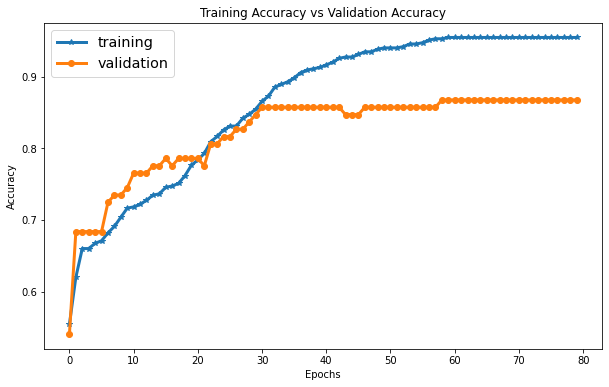

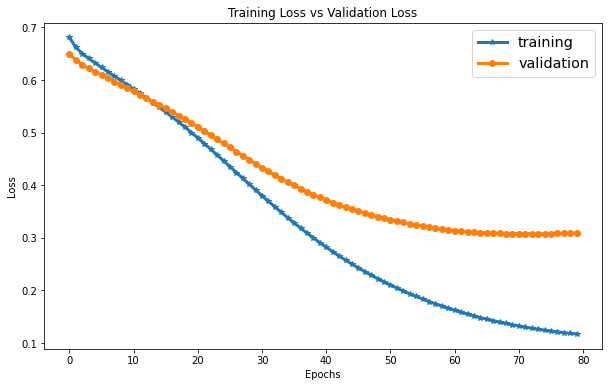

In [10]:
import matplotlib.pyplot as plt
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

In [ ]:
# Save the model to disk
model.save('saved_model')

# Predictions and Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

predictions = model.predict(validation_dataset)
predictions[0:6]

In [ ]:
predicted_class_indices=np.argmax(predictions,axis=1)
predicted_class_indices